## Behaviour Cloning Project Report
In this project, our purpose is to develop and train Deep Neural Network architecture to drive vehicle in a simulation environment. Labeled driving data is collected through manually driving the vehicle and recording images from various cameras as well as control inputs such as steering angle, throttle and brake status. In order to simplify the problem, we only control the steering angle and throttle amount will be fixed and controlled by simple PI controller. In order to evaluate project, rubrick given in this [link](https://review.udacity.com/#!/rubrics/432/view) is used. This project covers all the mandatory items in the rubrick. 

Outline of the project report is as follows:

1. List of project files and short explanation will be given.
2. Model architecture and training strategy will be discussed.

### Files
This project contains four files
1. ***model.py and helper.py***: All the model training related codes are given inside these two source files. Most of the functions including DNN model is in helper.py and model.py contains only the main function and function calls. In order to run just run model.py function '''python model.py''' In each call, model is trained from scratch.
2. ***model.h5***: Trained model will be saved into this file
3. ***drive.py***: Contains interface functions with the simulator. This function loads pretrained model file and image frame from simulator and predicts steering angle. Predicted angle as well as throttle value is feeded back to the simulator.

### Model architecture and training strategy
I have tested two different DNN models. First one is the simple LeNet architecture and the second one is NVidia model. I am not quite sure how LeNet performs because I have tested it at the beginning of project development without much data augmentation or overfit reducing methods applied. LeNet model was performing poorly however this may be attributed to the unstructured training data. Later, I started testing with NVidia model. It was also performing poorly however it become better and better as I worked on augmentation and cleaning methods. I will share final LeNet and NVidia achitectures that I used here:


In [1]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Cropping2D
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2, activity_l2

def build_preprocess_layers():
    """
    Build first layer of the network, normalize the pixels to [-1,1]
    """
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=(66,200,3)))
                     
    return model

def build_lenet_model():
    """
    Build a LeNet model using keras
    """
    model = build_preprocess_layers()
    model.add(Convolution2D(6, 5, 5, activation="relu"))
    model.add(MaxPooling2D())
    model.add(Convolution2D(6, 5, 5, activation="relu"))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dense(84))
    model.add(Dense(1))

    return model

def build_nvidia_model():
    """
    Build a NVidia model using keras
    """
    model = build_preprocess_layers()
    
    # Add three 5x5 convolution layers (output depth 24, 36, and 48), each with 2x2 stride
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid', W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid', W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='valid', W_regularizer=l2(0.001)))
    model.add(ELU())
    
    # Add two 3x3 convolution layers (output depth 64, and 64)
    model.add(Convolution2D(64, 3, 3, border_mode='valid', W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, border_mode='valid', W_regularizer=l2(0.001)))
    model.add(ELU())

    # Add a flatten layer
    model.add(Flatten())

    # Add three fully connected layers (depth 100, 50, 10), tanh activation (and dropouts)
    model.add(Dense(100, W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Dense(50, W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Dense(10, W_regularizer=l2(0.001)))
    model.add(ELU())

    # Add a fully connected output layer
    model.add(Dense(1))

    return model


from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot



Using TensorFlow backend.


#### LeNet model

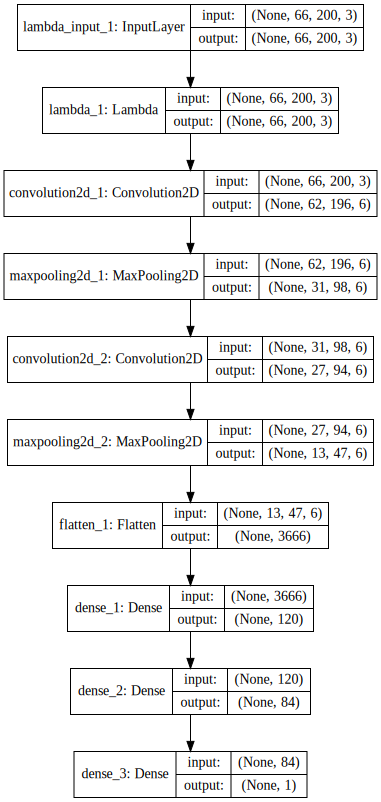

In [2]:
SVG(model_to_dot(build_lenet_model(),show_shapes=True).create(prog='dot', format='svg'))

#### NVidia Model

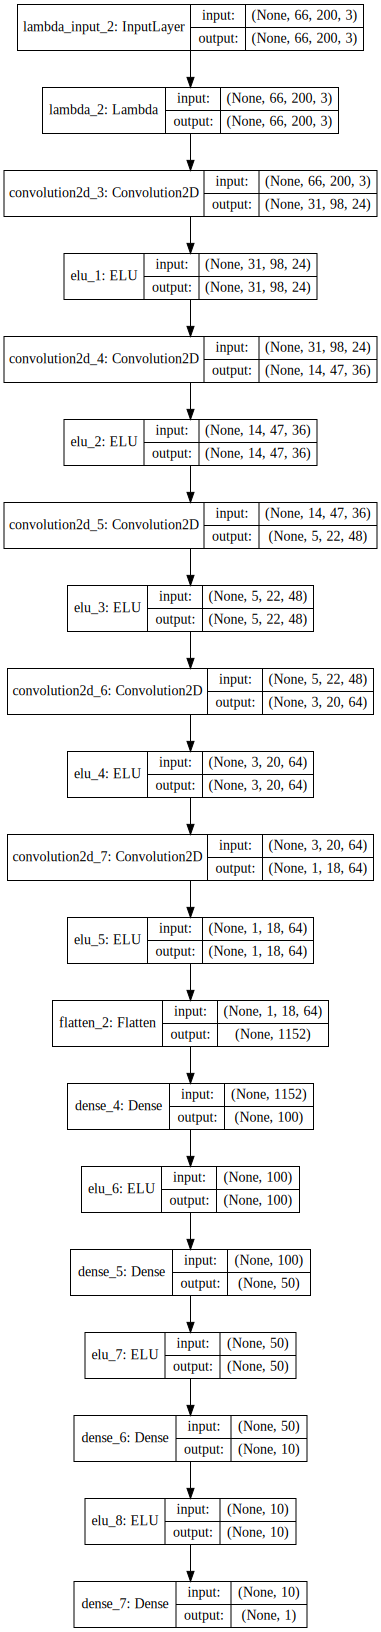

In [3]:
SVG(model_to_dot(build_nvidia_model(),show_shapes=True).create(prog='dot', format='svg'))

#### Tranining strategy
From the lectures we learned several method to keep in mind to develop good training strategy. However, I started from simple model and minimal data augmentation to see how simple model behaves. I have noticed that without any data augmentation and with simple LeNet model, car can already navigate up to certain point in the track. First failed happened just before the bridge and next failure was just after the bridge. Then, I am convinced that simple model without any data augmentation and preprocessing would not suffice to complete the track. Because I read some guiding articles on this project, I already knew that data is very important and I started to preprocess data and augment data.

##### Preprocessing the data
First, I cropped the camera image as to contain only the road segment. I cropped 45 pixel from above and 15 pixels from below of the image. Next, I added gaussian blur and resized image to 66x200 in order to fit nvidia model. Lastly, I converted color space from BGR to YUV as suggested in the NVidia paper. Last but not least, I randomly selected half of the total images and flipped in the horizontal axis to balance number of left and right turns. 

##### Visualizing the data
After applying preprocessing method, I visualized the data and respective steering angle in order to make sure preprocessing steps worked well and steering angle labels are accurate.

I overlaid the steering angle on top of the preprocessed image.

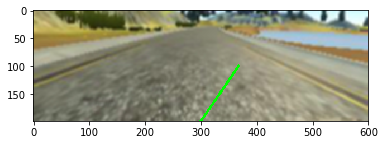

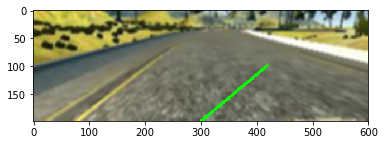

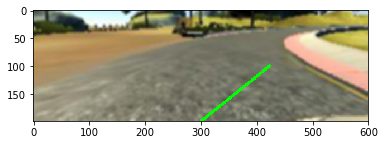

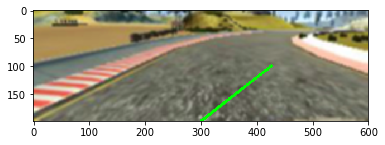

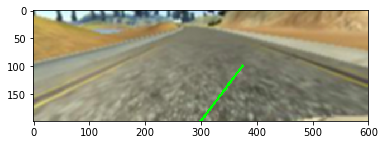

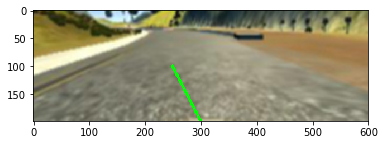

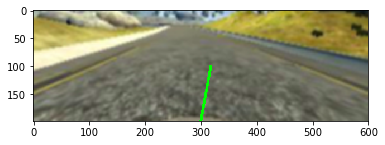

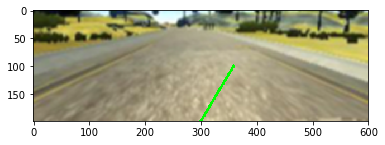

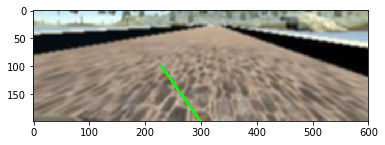

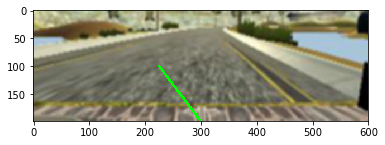

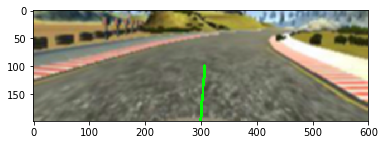

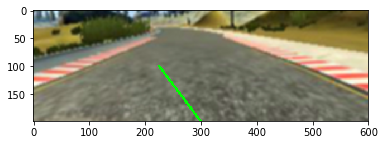

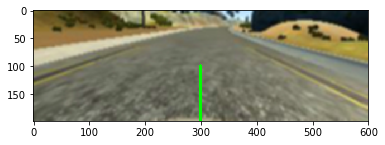

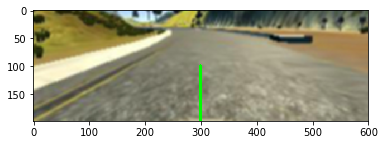

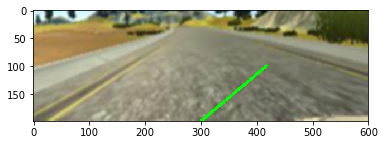

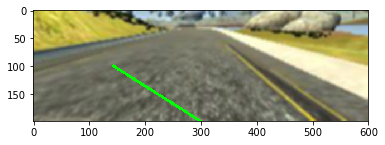

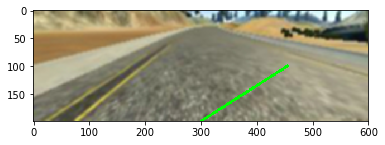

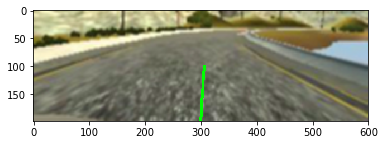

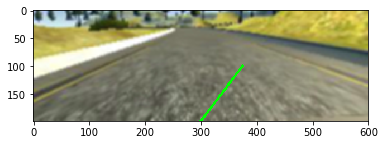

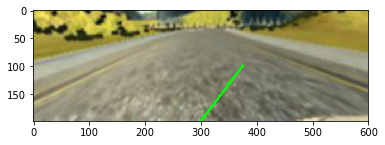

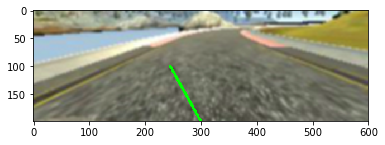

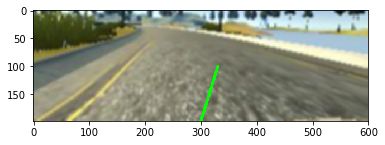

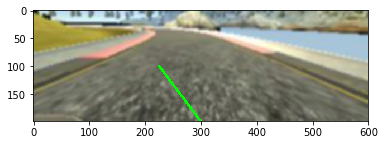

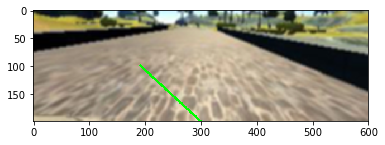

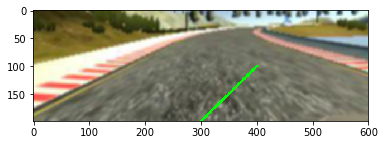

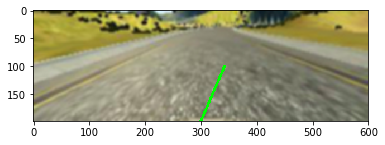

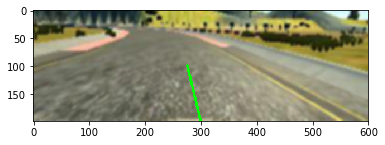

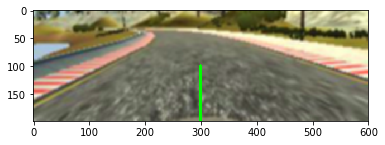

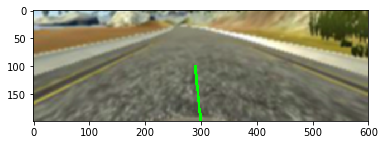

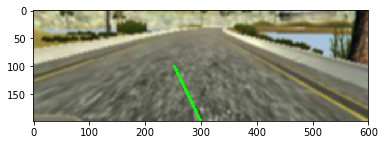

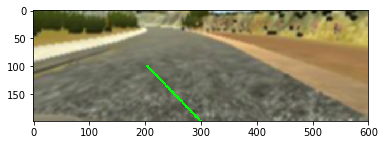

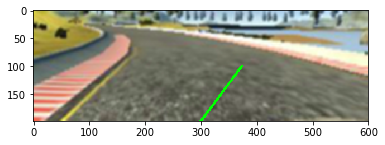

In [4]:
import utils
import helper
from sklearn.model_selection import train_test_split
%matplotlib inline

image_filenames = [] 
angles = []

image_filenames, angles = helper.readDataset(image_filenames, angles, './data/driving_log.csv','./data/IMG/')
#image_filenames, angles = helper.readDataset(image_filenames, angles, './recorded/driving_log.csv','./recorded/IMG/')

#image_filenames, angles = helper.removeOverrepresentedData(image_filenames, angles)

image_filenames_train, image_filenames_test, angles_train, angles_test = train_test_split(image_filenames, angles, test_size=0.2)
    

# compile and train the model using the generator function
train_generator = helper.samples_generator(image_filenames_train, angles_train, batch_size=32)
validation_generator = helper.samples_generator(image_filenames_test, angles_test, batch_size=32)

X, y = next(train_generator)
helper.visualizeDataset(X, y)

Next, I visualized the distribution of the steering angle in the dataset and realized that most of the data has almost zero steering angle. This makes sense because car goes straight most of the time. 

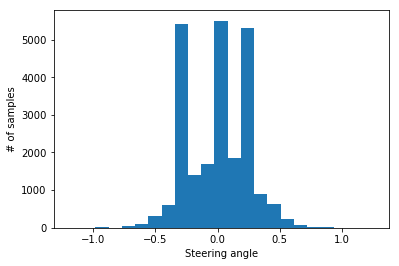

In [5]:
helper.visualizeDataDistribution(angles)

However, this causes model to learn go straight mosltly and car cannot take sharp turns. In order to balance steering angle distribution, I removed if certain angles has more samples than specified threshold. This step is done inside removeOverrepresentedData() function:

```python
def removeOverrepresentedData(filenames,angles, ):
    """
    Balances the distribution of driving data based on steering angles
    """
    
    hist,bins = np.histogram(angles,bins=23)

    thres = int(np.average(hist))

    bins_to_prune = [i for i,v in enumerate(hist) if v > thres]

    for bin_idx in bins_to_prune:
        bin_elements = [i for i,v in enumerate(angles) if (v > bins[bin_idx] and v < bins[bin_idx+1])]
        bin_elements_to_remove = random.sample(bin_elements, len(bin_elements)-thres)

        filenames = np.delete(filenames, bin_elements_to_remove)
        angles = np.delete(angles, bin_elements_to_remove)

    return filenames,angles
```

After removing overrepresented data, distribution of the remaining data is as follows:

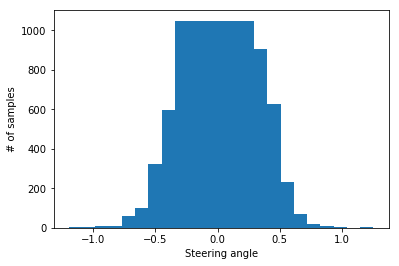

In [6]:
image_filenames, angles = helper.removeOverrepresentedData(image_filenames, angles)
helper.visualizeDataDistribution(angles)

##### Data augmentation
As suggested in the project description, I used left and right camera to augment training data. I used -+25 degree bias to steering angle. Other than that I didn't used any other augmentation technique. 

##### Collecting more data
I mainly trained model using the provided data. I tried collecting my own data but realized that collecting accurate driving data is very challenging and decided to continue using provided data. However, I did collect my own training data to augment missing data especially at sharp turns. 

##### Reducing overfitting
In order to reduce overfitting, I used regularization layers in the DNN model. Also, dropout layers can be added after rectifier units. As I know their effect will not be significant, I focused on improving the data pre-processing step instead.

##### Using generator functions
As suggested in the project description, I used generator function to generate random batch samples for training. I used this generator both in random data visualization and training step.

##### Additional remarks
I have realized that when data is collected vehicle speed was around 15 MPH however I did my test in 9 MPH. Therefore training and test setups was not identical. Ideally, training and test speed should be same or we need to use speed as a training input. I tried increasing drive speed but that made control harder and caused car to crash. It is easier to control car at lower speed. I will leave training model to drive at higher speeds as one of the ToDo items for the future.

### Driving demo
I tested my trained model in the first track only and it worked quite well in the final version of my trained model. Of course, there are lots of items to improve but I will leave them as ToDo items to complete in the future.

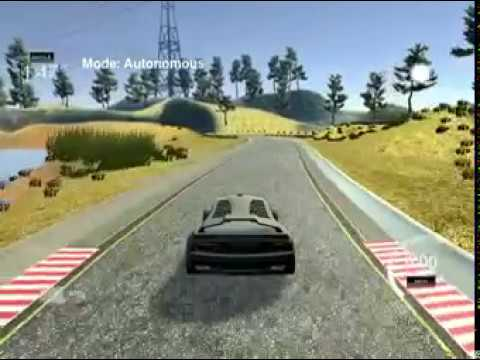

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo("JMqM6vM-Z6w")

#### Conclusion and  ToDo items

As conclusion, I really enjoyed working on this project and I would like to come back later and try several improvement items in my mind. 

1. Try this model in the second challange track
2. Try different DNN models and tweak model parameters
3. Add more data augmentation techniques. Add random warping and random illumination change to image.
4. Use more training data.
5. Reduce the effects of surrounding environment. Extract the road surface or boundaries of the road and decide based on road boundaries only.